In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

path1 = './face/'
path2 = './non-face/'

face_list = os.listdir(path1)
nonface_list = os.listdir(path2)

def readimg(file_path):
    img = cv2.imread(file_path, 0)
    height, width = img.shape
    vector_size = height*width
    img_vector = img.reshape(1, vector_size)
    return img_vector


face_cube = readimg(path1+face_list[0])

for line in face_list:
    tmp_vector = readimg(path1+line)
    face_cube = np.append(face_cube, tmp_vector, axis = 0)
    
nonface_cube = readimg(path2+nonface_list[0])

for line in nonface_list:
    tmp_vector = readimg(path2+line)
    nonface_cube = np.append(nonface_cube, tmp_vector, axis = 0)
    
def face_show(index):
    img = face_cube[index,:].reshape(32,32)
    plt.imshow(img,cmap = 'gray')

def nonface_show(index):
    img = nonface_cube[index,:].reshape(32,32)
    plt.imshow(img,cmap = 'gray')

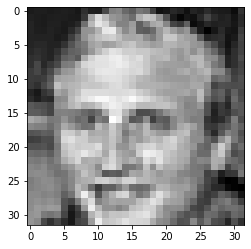

In [2]:
face_show(3000)

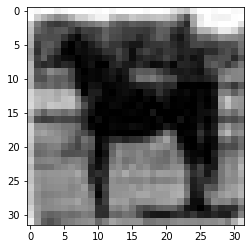

In [3]:
nonface_show(200)

In [4]:
img_set = np.append(face_cube, nonface_cube, axis = 0)

In [5]:
img_set.shape

(11994, 1024)

In [14]:
label = np.zeros(len(img_set))
# 1 for face , 0 for nonface
label[:len(face_cube)] = 1
label[len(face_cube):len(nonface_cube)] = 0
Normal_pairs = [(img_set[i], label[i]) for i in range(len(img_set))]

import random
random.shuffle(Normal_pairs)
Training_set = Normal_pairs[:int(len(img_set)*0.5)]
Test_set = Normal_pairs[int(len(img_set)*0.5)+1:int(len(img_set))]

In [7]:
len(Training_set)

5997

In [8]:
len(Test_set)

5996

In [9]:
Training_label = [Training_set[i][1] for i in range(len(Training_set))]
Training_data = [Training_set[i][0] for i in range(len(Training_set))]

Training_data = np.array(Training_data)
Training_label = np.array(Training_label)

Test_label = np.array([Test_set[i][1] for i in range(len(Test_set))])
Test_data = np.array([Test_set[i][0] for i in range(len(Test_set))])

In [10]:
Training_data

array([[  8,  16,  24, ..., 107, 108, 138],
       [  8,  16,  24, ..., 107, 108, 138],
       [ 63,   3,  16, ...,  53,  53, 100],
       ...,
       [158, 162, 167, ...,   0,  11,   7],
       [ 12,   2,   0, ...,  82,  87,  82],
       [ 93,  94,  94, ...,  94,  96,  99]], dtype=uint8)

In [31]:
img_set = img_set - img_set.mean(axis = 0)
img_set[:5]
cov_mat = np.cov(img_set.T, bias=True)
eig_val, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [(np.abs(eig_val[i]), eig_vecs[:,i]) for i in range(len(eig_val))]
eig_pairs.sort(key = lambda x: x[0], reverse=True)

cond = (eig_val/eig_val.sum()).cumsum()
cond = cond >=0.90
index = cond.argmax()

vector = eig_vecs[:,:index+1]
PCA_result = np.dot(img_set, vector)
PCA_pairs = [(PCA_result[i], label[i]) for i in range(len(PCA_result))]

In [33]:
def Gaussian_Generative(X):
    
    Means = X.mean(axis = 0)
    temp = np.zeros((1024, 1024))
    cov = np.cov(X.T, bias=True)
    return Means, cov

In [35]:
PCA_face =  np.array([PCA_pairs[i][0] for i in range(len(face_cube))])
PCA_nonface = np.array([PCA_pairs[i][0] for i in range(len(face_cube)+1, len(face_cube) + len(nonface_cube))])

PCA_Face_Means, PCA_Face_cov = Gaussian_Generative(PCA_face)
PCA_Nonface_Means, PCA_Nonface_cov = Gaussian_Generative(PCA_nonface)


In [39]:
def prediction(Face_cov, Nonface_cov, x, theta):
    
    M = 0.5*(np.linalg.inv(Nonface_cov) - np.linalg.inv(Face_cov))
    w = np.linalg.inv(Face_cov) - np.linalg.inv(Nonface_cov)
    
    x = x.reshape(len(x),1)
    result = np.mat(x.T)*np.mat(M)*np.mat(x) + 2*np.matmul(w.T, x)
    #print(result.mean)
    if (np.sum(result)/len(x) > theta):
        predict_label = 1
    else:
        predict_label = 0
        
    return predict_label

In [40]:
random.shuffle(PCA_pairs)

PCA_Test_set = PCA_pairs[int(len(img_set)*0.5)+1:int(len(img_set))]

PCA_Test_label = np.array([PCA_Test_set[i][1] for i in range(len(PCA_Test_set))])
PCA_Test_data = np.array([PCA_Test_set[i][0] for i in range(len(PCA_Test_set))])

In [42]:
# test
prediction(PCA_Face_cov, PCA_Nonface_cov, PCA_Test_data[400], 0)

1

In [49]:
def compute_accuracy(Face_cov, Nonface_cov, x, y, theta):
    
    count = 0
    size = len(x)
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    for i in range(size):
        predict = prediction(Face_cov, Nonface_cov, x[i], 0)
        if(predict == y[i]):
            count = count + 1
            if (y[i] == 1):
                TP += 1
            else:
                TN += 1

        else:
            if(y[i] == 1):
                FN += 1
            else:
                FP += 1

    accu = (count+0.0)/size
    
    return TP, TN, FN, FP, accu

In [50]:
TP, TN, FN, FP, accu = compute_accuracy(PCA_Face_cov, PCA_Nonface_cov, PCA_Test_data, PCA_Test_label, 0)

In [51]:
print('--------- P------N-------- ')
print('----T----', TP,'----', TN, '------------')
print('----F----', FP,'----', FN, '------------')

--------- P------N-------- 
----T---- 2719 ---- 2909 ------------
----F---- 51 ---- 317 ------------


In [52]:
accu

0.9386257505003336

In [54]:
Face_set = img_set[:len(face_cube)]
Nonface_set = img_set[(len(face_cube))+1:]

In [55]:
Face_Means, Face_cov = Gaussian_Generative(Face_set)
Nonface_Means, Nonface_cov = Gaussian_Generative(Nonface_set)

In [56]:
Face_set[300].shape

(1024,)

In [57]:
M = 0.5*(np.linalg.inv(Nonface_cov) - np.linalg.inv(Face_cov))
w = np.linalg.inv(Face_cov) - np.linalg.inv(Nonface_cov)

In [58]:
def predict(x, theta):
    x = x.reshape(1024,1)
    result = np.mat(x.T)*np.mat(M)*np.mat(x) + 2*np.matmul(w.T, x)
    #print(result.mean)
    if (np.sum(result)/len(x) > theta):
        predict_label = 1
    else:
        predict_label = 0
    return predict_label

In [59]:
# test
predict(Nonface_set[2], 0)

0

In [60]:
import random
random.shuffle(Normal_pairs)
Test_set = Normal_pairs[int(len(img_set)*0.5)+1:int(len(img_set))]

Test_label = np.array([Test_set[i][1] for i in range(len(Test_set))])
Test_data = np.array([Test_set[i][0] for i in range(len(Test_set))])

In [61]:
def compute_accuracy(x, y, theta):
    
    count = 0
    size = len(x)
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    for i in range(size):
        prediction = predict(x[i], theta)
        if(prediction == y[i]):
            count = count + 1
            if (y[i] == 1):
                TP += 1
            else:
                TN += 1

        else:
            if(y[i] == 1):
                FN += 1
            else:
                FP += 1

    accu = (count+0.0)/size
    
    return TP, TN, FN, FP, accu

In [62]:
TP, TN, FN, FP, accu = compute_accuracy(Test_data, Test_label, 0)

In [63]:
print('--------- P------N-------- ')
print('----T----', TP,'----', TN, '------------')
print('----F----', FP,'----', FN, '------------')

--------- P------N-------- 
----T---- 2953 ---- 2855 ------------
----F---- 187 ---- 1 ------------


In [64]:
accu

0.9686457638425617